# Final Project Example

## Retrieve/Scrape the Data

In [ ]:
import requests
import json
import pandas as pd

bearer_token = 'AAAAAAAAAAAAAAAAAAAAAGQvMQEAAAAAJ3DsIoP%2FZadSuqr0iajMvuOFyZU%3DjevRvOrRSVMeoTctJGqK5dW2BBdbbRLKE3aOTfbWIhMIhvPViC'
headers = {'Authorization':('Bearer '+ bearer_token)}

# In this example, only those tweets with photos/images are stored

n = 5000                          # The total number of tweets we want
max_results = 100                 # The number of tweets to pull per request; must be between 10 and 100
total_retrieved = 0               # To keep track of when to stop
next_token = ""                   # Must be empty on first iteration
search_term = "covid"  # To form an advanced query, see here: https://twitter.com/search-advanced?lang=en
since_id = "1373000000000000000"  # The id of the oldest tweet you want to retrieve

# Create the empty DataFrame with the columns you want
df = pd.DataFrame(columns=['id', 'created_at', 'retweets', 'likes', 'replies', 'quotes', 'user_followers', 'user_following', 'user_listed', 'user_tweets', 'has_media', 'url', 'lang', 'text'])
df.set_index('id', inplace=True)

# stop when we have n results
while total_retrieved < n:

  # the first time through the loop, we do not need the next_token parameter
  if next_token == "":
    url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}&since_id={since_id}'
  else:
    url = f'https://api.twitter.com/2/tweets/search/recent?query={search_term}&max_results={max_results}&since_id={since_id}&next_token={next_token}'

  # These are the extra parameters we will add to the querystring; we won't store them all though; just want you to see what's possible
  url += f'&user.fields=id,public_metrics'
  url += f'&tweet.fields=attachments,public_metrics,text,created_at,author_id,lang'
  url += f'&expansions=attachments.media_keys,author_id'
  url += f'&media.fields=media_key,type,url'

  # make the request to the Twitter API Recent Search endpoint
  response = requests.request("GET", url, headers=headers)
  try:  # Just in case we get an error
    json_data = json.loads(response.text)
  except:
    print(response.text)
  
  # Error checking; print the results if valid data is not retrieved
  if not 'data' in json_data:
    json_clean = json.dumps(json_data, indent=2, sort_keys=True)
    print(json_clean)
    continue


  for tweet in json_data['data']:
    media_key = ""  # Reset to empty each time through the loop so that we can use it for a condition later

    # Store the data into variables
    tweet_id = tweet['id']
    try:
      author_id = tweet['author_id']
    except:
      print(tweet)
    created_at = tweet['created_at']
    retweet_count = tweet['public_metrics']['retweet_count']
    like_count = tweet['public_metrics']['like_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    user_followers = ""
    user_following = ""
    user_listed = ""
    user_tweets = ""
    has_media = False
    image_url = ""
    lang = tweet['lang']
    text = tweet['text']

    # Find out if there is media
    if 'attachments' in tweet:
      if 'media_keys' in tweet['attachments']:
        media_key = tweet['attachments']['media_keys'][0]
        
    # Iterate through all authors until we find the author of this tweet; then store their metrics
    for author in json_data['includes']['users']:
      if author['id'] == author_id:
        user_followers = author['public_metrics']['followers_count']
        user_following = author['public_metrics']['following_count']
        user_listed = author['public_metrics']['listed_count']
        user_tweets = author['public_metrics']['tweet_count']
        break

    # If there is a media key in this tweet, iterate through tweet['includes']['media'] until we find it
    if media_key != "":
      for media in json_data['includes']['media']:
        if media['media_key'] == media_key: # Only if the media_key matches the one we stored
          has_media = True
          if media['type'] == 'photo':      # Only if it is a photo; ignore videos
            image_url = media['url']        # Store the url in a variable
            
            # Only collect english tweets (to aid the natural language processing) that include a .jpg photo
            if (lang == 'en') and (image_url.split('.')[-1] == 'jpg'):
              total_retrieved += 1
              df.loc[tweet_id] = [created_at, retweet_count, like_count, reply_count, quote_count, user_followers, user_following, user_listed, user_tweets, has_media, image_url, lang, text]
            else:
              continue
            break

  # keep track of where to start next time, but quit if there are no more results
  try:
    #  total_retrieved += json_data['meta']['result_count'] # Use this when you have no other criterion for which tweets to keep
    next_token = json_data['meta']['next_token']
  except:
    break
    
  print(f'{total_retrieved}, ', end='') # This simply shows something in the output so that we know the loop is running

# Parse out the date into potentially useful features
df['created_at'] = pd.to_datetime(df['created_at'])
df['Weekday'] = df['created_at'].dt.day_name()
df['DayOfWeek'] = df['created_at'].dt.dayofweek
df['Hour'] = df['created_at'].dt.hour
df.to_csv('twitter.csv')
df.head()

## Exploratory Data Analysis (i.e. Data Understanding Phase)
### Begin with univariate analyses

In [ ]:
import pandas as pd
df = pd.read_csv('twitter.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.head()

In [ ]:
df.drop(columns=['created_at'], inplace=True)
df.describe()

In [ ]:
df.skew()


  
### Continue with bivariate analyses

In [ ]:
# Create a heatmap over a correlation table

import seaborn as sns
sns.set_style("whitegrid")
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2f', 
            vmin=-1, vmax=1, center=0, cmap= 'coolwarm', 
            mask=matrix, square=True);

In [ ]:
df.dtypes

In [ ]:
sns.set(color_codes=True)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.jointplot(x='likes', y='quotes', data=df);

In [ ]:
sns.barplot(data=df, x="has_media", y="retweets");

# Text Processing

In [321]:
!pip install --upgrade pip
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install bokeh
!pip install gensim
!pip install spacy
!pip install logging
!pip install wordcloud
!pip install warnings
!pip install matplotlib
!pip install nltk
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install -U seaborn
!pip install translators --upgrade
#!conda install -c conda-forge pyldavis

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim
ERROR: No matching distribution found for pyLDAvis.gensim
ERROR: Could not find a version that satisfies the requirement warnings
ERROR: No matching distribution found for warnings
     |████████████████████████████████| 13.7 MB 4.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Translate Non-English Tweets to English

In [322]:
import pandas as pd
df = pd.read_csv('twitter.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.lang.value_counts()

(502, 17)


en    502
Name: lang, dtype: int64

In [323]:
def translate(text):
  import translators as ts
  translated = ""

  # professional field
  try:
    translated = ts.alibaba(text, professional_field='general') # ("general","message","offer")
  except:
    pass

  if translated == "":
    try:
      translated = ts.baidu(text, professional_field='common') # ('common','medicine','electronics','mechanics')
    except:
      pass

  # host service
  if translated == "":
    try:
      translated = ts.google(text, if_use_cn_host=True)
      translated = ts.bing(text, if_use_cn_host=False)
    except:
      pass

  return translated

for i, row in enumerate(df.itertuples()):
  if row[13] != 'en':
#     df.loc[row[0]] = translate(df.loc[row[0]][13])
    print(row[13], df.loc[row[0]][13])

In [324]:
df.to_csv('twitter.csv', index=False)

### Generate Stop Words List

In [326]:
import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings, en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'co', 'https', 'http', 'twitter', 'amp', 'covid', 'gofundme']) # After reviewing the LDA, return to add words that you want to eliminate

ImportError: cannot import name 'lemmatize' from 'gensim.utils' (/opt/conda/lib/python3.7/site-packages/gensim/utils.py)

### Tokenize and Clean
Remove line breaks, single quotes, email addresses.
Use Gensim's simple_preprocess to hash/tokenize each string

In [327]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\\S*@\\S*\\s?', '', sent)  # remove emails
        sent = re.sub('\\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert each tweet to a list of cleaned words and add to a master list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
  print(tweet)

df['words'] = data_words
df.head()

['city', 'of', 'weston', 'broward', 'covid', 'data', 'and', 'florida', 'vaccination', 'progress', 'for', 'march', 'th', 'westonfl', 'weston', 'browardcounty', 'broward', 'florida', 'covid', 'covid', 'coronavirus', 'march', 'th', 'wearamask', 'https', 'co', 'zpide', 'korm']
['check', 'out', 'our', 'latest', 'edition', 'of', 'great', 'happens', 'here', 'stay', 'connected', 'with', 'the', 'latest', 'covid', 'protocols', 'and', 'updates', 'school', 'of', 'choice', 'links', 'staff', 'celebrations', 'graduation', 'planning', 'and', 'more', 'https', 'co', 'uzn', 'bonqyw', 'ghh', 'psdproud', 'psdtogether', 'https', 'co', 'oifsyygd']
['first', 'covid', 'vaccine', 'done', 'weeks', 'until', 'the', 'next', 'one', 'https', 'co', 'rkw', 'aia']
['donald', 'trumps', 'mar', 'lago', 'resort', 'to', 'reopen', 'dining', 'facilities', 'following', 'covid', 'outbreak', 'https', 'co', 'cuvmacpmce', 'https', 'co', 'ezmf', 'vlzix']
['how', 'has', 'the', 'covid', 'pandemic', 'changed', 'how', 'organizations', '

,id,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,has_media,url,lang,text,Weekday,DayOfWeek,Hour,words
0,1375208912442454018,2021-03-25 22:12:09+00:00,0,0,0,0,18,37,5,961,True,https://pbs.twimg.com/media/ExW5NuSVEAEkjjK.jpg,en,City of Weston / Broward COVID-19 Data and Flo...,Thursday,3,22,"[city, of, weston, broward, covid, data, and, ..."
1,1375208907837206529,2021-03-25 22:12:08+00:00,0,0,0,0,5669,651,138,8140,True,https://pbs.twimg.com/media/ExW5NtDXAA4TXyT.jpg,en,Check out our latest edition of Great Happens ...,Thursday,3,22,"[check, out, our, latest, edition, of, great, ..."
2,1375208902921486340,2021-03-25 22:12:07+00:00,0,0,0,0,442,878,3,16456,True,https://pbs.twimg.com/media/ExW5NVRXIAc_n4k.jpg,en,First Covid 19 vaccine done! 3 weeks until the...,Thursday,3,22,"[first, covid, vaccine, done, weeks, until, th..."
3,1375208892695646212,2021-03-25 22:12:04+00:00,0,0,0,0,3646,133,236,95352,True,https://pbs.twimg.com/media/ExW5MptVcAQLTrn.jpg,en,Donald Trump's Mar-a-Lago resort to reopen din...,Thursday,3,22,"[donald, trumps, mar, lago, resort, to, reopen..."
4,1375208876748988421,2021-03-25 22:12:01+00:00,0,0,0,0,1578,1087,106,4695,True,https://pbs.twimg.com/media/ExW5L4fXAAUvWas.jpg,en,How has the COVID-19 pandemic changed how orga...,Thursday,3,22,"[how, has, the, covid, pandemic, changed, how,..."


In [328]:
length = ''
for i in range(len(data_words)):
    for j in range(len(data_words[i])):
        length += data_words[i][j]
print(f'Corpus size: {str(len(length))}')

Corpus size: 63604


### Add Bigrams, Trigrams, and Stem

In [329]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Remove stop words, add bigrams and trigrams, performed lemmatization/stemming

In [330]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and perform Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)
for tweet in data_ready[:5]:
  print(tweet)

df['words'] = data_ready

['city', 'weston', 'broward', 'datum', 'florida', 'vaccination', 'progress', 'march', 'westonfl', 'weston', 'browardcounty', 'broward', 'florida', 'coronavirus', 'march', 'th', 'wearamask', 'zpide', 'korm']
['check', 'late', 'edition', 'great', 'happen', 'stay', 'connected', 'late', 'protocol', 'update', 'school', 'choice', 'link', 'staff', 'celebration', 'graduation', 'planning', 'uzn', 'bonqyw', 'ghh', 'psdproud', 'psdtogether', 'oifsyygd']
['first', 'vaccine', 'week', 'rkw', 'aia']
['donald', 'trump', 'mar', 'lago', 'resort', 'reopen', 'dining', 'facility', 'follow', 'outbreak', 'cuvmacpmce', 'ezmf', 'vlzix']
['pandemic', 'change', 'organization', 'focus', 'sustainability', 'find', 'buifspnxpp', 'smartbuilding', 'kqor', 'alaxq']


## **LDA Topic Model: Tweet Text**

### Build an LDA 
Build Latent Dirichlet Allocation model for detecting the top n topics in the corpus

In [343]:
def lda(data_ready=None, id2word=None, corpus=None, start=2, iterations=10, every=2):
  coherence_list = []
    
  print(f'Topics\tPerplexity\tCoherence')
  for topics in range(start, (start + iterations) * every, every):
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, random_state=100,
                                                update_every=1, chunksize=20, passes=20, alpha='symmetric',
                                                iterations=500,per_word_topics=True)

    # Compute LDA metrics
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    print(f'{topics}\t{round(lda_model.log_perplexity(corpus), 4)}\t\t{round(coherence_model_lda.get_coherence(), 4)}')
    coherence_list.append(coherence_model_lda.get_coherence())

  # Determine the numer of topics for the LDA with the highest coherence score
  best_topics = (coherence_list.index(max(coherence_list)) + start) * every
    
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=best_topics, random_state=100,
                                              update_every=1, chunksize=20, passes=20, alpha='symmetric',
                                              iterations=500,per_word_topics=True)

  ldatopics = lda_model.show_topics(formatted=False)
  pprint(lda_model.print_topics())
  return lda_model


# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

lda_model = lda(data_ready, id2word, corpus, start=2, iterations=9, every=1)
num_topics = len(lda_model.get_topics())

Topics	Perplexity	Coherence
2	-8.3288		0.4871
3	-8.5101		0.6713
4	-8.6857		0.5626
5	-8.7727		0.4952
6	-8.855		0.4847
7	-8.9429		0.5289
8	-8.9583		0.5038
9	-9.0809		0.5046
10	-9.4595		0.4968
[(0,
  '0.030*"case" + 0.019*"look" + 0.017*"surge" + 0.016*"hspr" + '
  '0.016*"countries_move" + 0.006*"pandemic" + 0.006*"thank" + 0.005*"need" + '
  '0.005*"vaccine" + 0.005*"support"'),
 (1,
  '0.013*"health" + 0.009*"nqeniugakn" + 0.009*"ward_nurse" + 0.009*"pesanan" '
  '+ 0.006*"get" + 0.005*"see" + 0.005*"say" + 0.004*"way" + 0.004*"plan" + '
  '0.004*"let"'),
 (2,
  '0.023*"go" + 0.018*"score" + 0.013*"report" + 0.012*"vaccine" + '
  '0.011*"week" + 0.010*"icu" + 0.009*"come" + 0.009*"mortality" + '
  '0.009*"increase" + 0.009*"israel"')]


### Dominant Topic
What is the Dominant topic and its % contribution in each tweet?

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [344]:
def store_topic_scores(ldamodel=None, corpus=None, texts=data, df=df):
  # Create the new, zeroed columns to store the topic scores, dominant topic, and dominant topic score
  df['Dominant_topic'] = 0
  df['Dominant_score'] = 0.0
  num_topics = len(ldamodel.get_topics())
  for col in range(num_topics):
    df[f'topic_{col + 1}'] = 0.0
    
  # Store the topic score and dominant topic
  for i, words in enumerate(texts):
    doc = ldamodel[id2word.doc2bow(words)] # generate a corpus for this document set of workds
        
    for j, score in enumerate(doc[0]):
      df.iat[i, (len(df.columns) - ((num_topics) - score[0]))] = score[1]
        
    topic_score_list = [x[1] for x in doc[0]]
    dominant_topic = topic_score_list.index(max(topic_score_list))
    df.at[i, 'Dominant_topic'] = dominant_topic + 1
    df.at[i, 'Dominant_score'] = topic_score_list[dominant_topic]
    
  return(df)

In [345]:
df = store_topic_scores(lda_model, corpus, data_ready)
df.to_csv(f'twitter_with_LDA.csv', index=False)
df.head()

,id,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,...,text,Weekday,DayOfWeek,Hour,words,Dominant_topic,Dominant_score,topic_1,topic_2,topic_3
0,1375208912442454018,2021-03-25 22:12:09+00:00,0,0,0,0,18,37,5,961,...,City of Weston / Broward COVID-19 Data and Flo...,Thursday,3,22,"[city, weston, broward, datum, florida, vaccin...",3,0.964394,0.017714,0.017892,0.964394
1,1375208907837206529,2021-03-25 22:12:08+00:00,0,0,0,0,5669,651,138,8140,...,Check out our latest edition of Great Happens ...,Thursday,3,22,"[check, late, edition, great, happen, stay, co...",3,0.901700,0.083018,0.015282,0.901700
2,1375208902921486340,2021-03-25 22:12:07+00:00,0,0,0,0,442,878,3,16456,...,First Covid 19 vaccine done! 3 weeks until the...,Thursday,3,22,"[first, vaccine, week, rkw, aia]",3,0.879799,0.059717,0.060484,0.879799
3,1375208892695646212,2021-03-25 22:12:04+00:00,0,0,0,0,3646,133,236,95352,...,Donald Trump's Mar-a-Lago resort to reopen din...,Thursday,3,22,"[donald, trump, mar, lago, resort, reopen, din...",2,0.449203,0.126199,0.449203,0.424597
4,1375208876748988421,2021-03-25 22:12:01+00:00,0,0,0,0,1578,1087,106,4695,...,How has the COVID-19 pandemic changed how orga...,Thursday,3,22,"[pandemic, change, organization, focus, sustai...",2,0.820656,0.148070,0.820656,0.031274


## **Visualize the LDA Topics**

### Frequency Distribution
How many words are in each tweet? When working with a large number of tweets, you want to know how big the tweet are as a whole and by topic. Let’s plot the tweet word counts distribution.

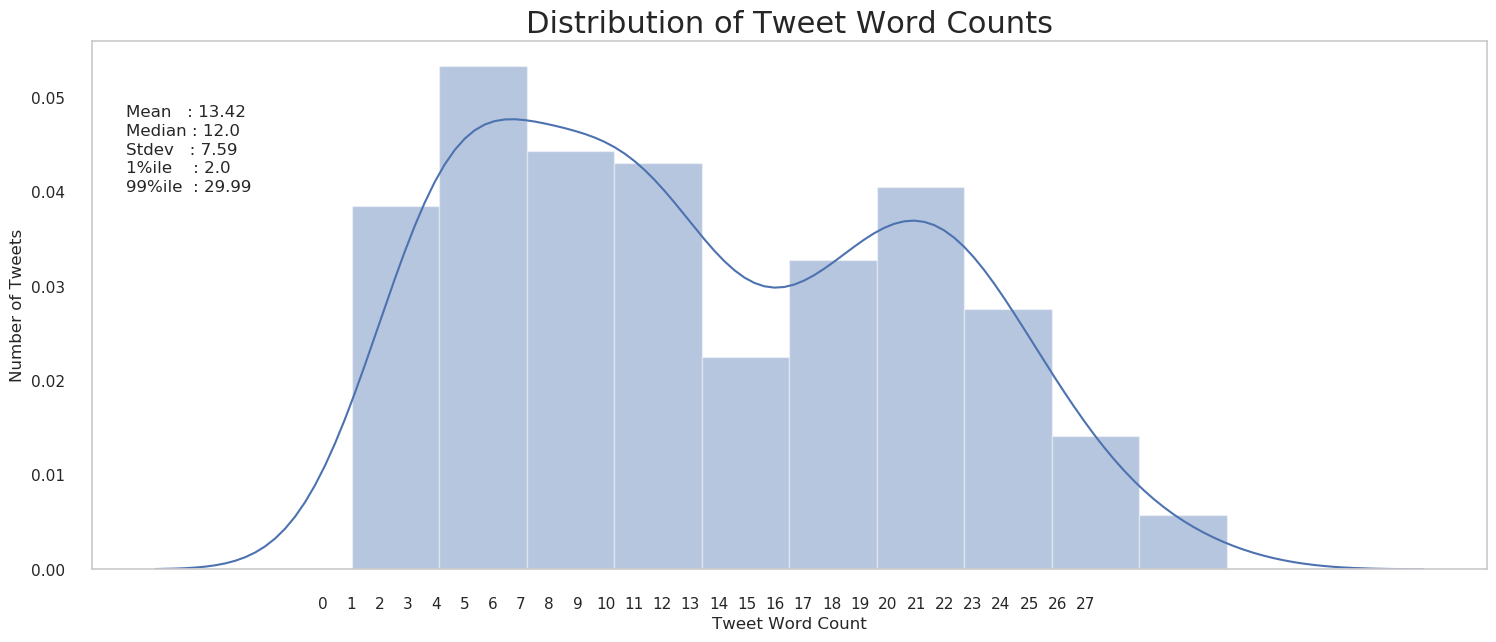

In [352]:
doc_lens = [len(d) for d in df.words]

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize=(18,7), dpi=100)
sns.distplot(doc_lens)
plt.text(-7, .048, "Mean   : " + str(round(np.mean(doc_lens), 2)))
plt.text(-7, .046, "Median : " + str(round(np.median(doc_lens), 2)))
plt.text(-7, .044, "Stdev   : " + str(round(np.std(doc_lens), 2)))
plt.text(-7, .042, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01), 2)))
plt.text(-7, .040, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99), 2)))

plt.gca().set(ylabel='Number of Tweets', xlabel='Tweet Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,27,28))
plt.title('Distribution of Tweet Word Counts', fontdict=dict(size=22))
plt.show()

### Word Counts by Dominant Topic

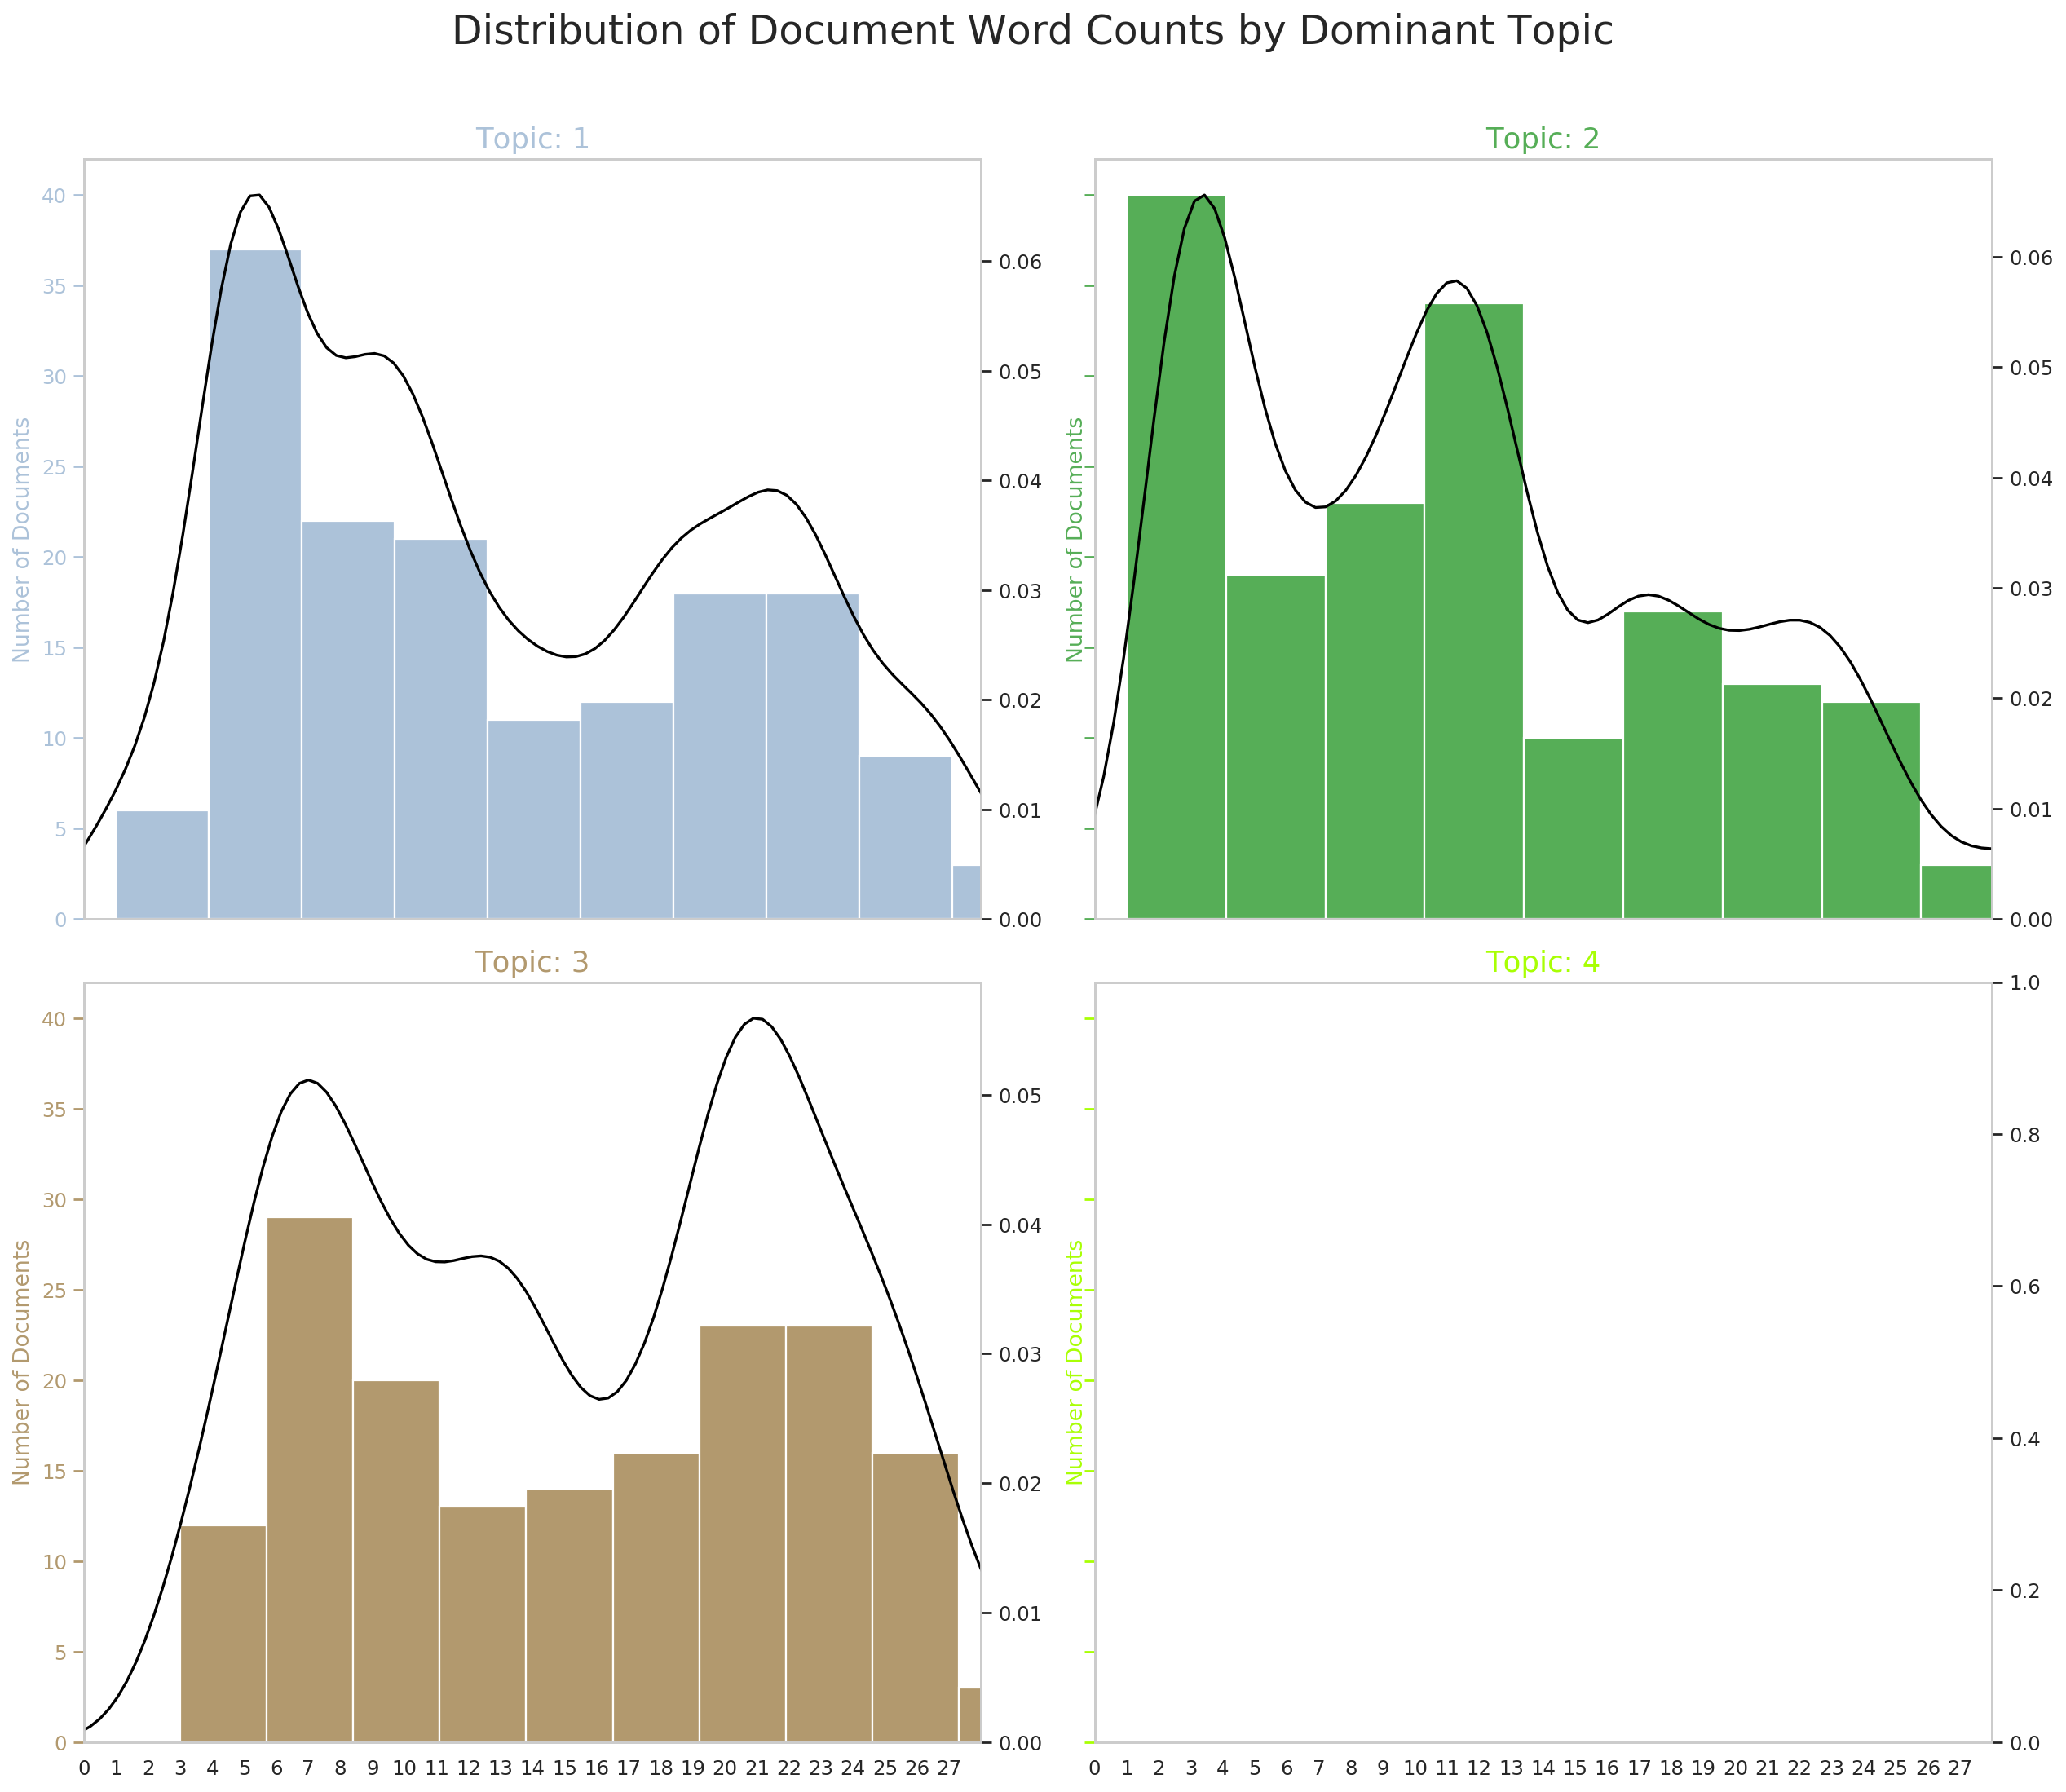

In [353]:
import matplotlib.colors as mcolors
import math
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS' or 'mcolors.CSS4_COLORS'

fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_sub = df.loc[df.Dominant_topic == (i + 1), :]
    doc_lens = [len(d) for d in df_sub.words]
    ax.hist(doc_lens, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx(), bw=1.5)
    ax.set(xlim=(0, 28), xlabel='')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i + 1), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,27,28))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Clouds of Top N Keywords
Update the max_words variable below to include more or less words per cloud. The coloring of the topics is used in subsequent vizs.

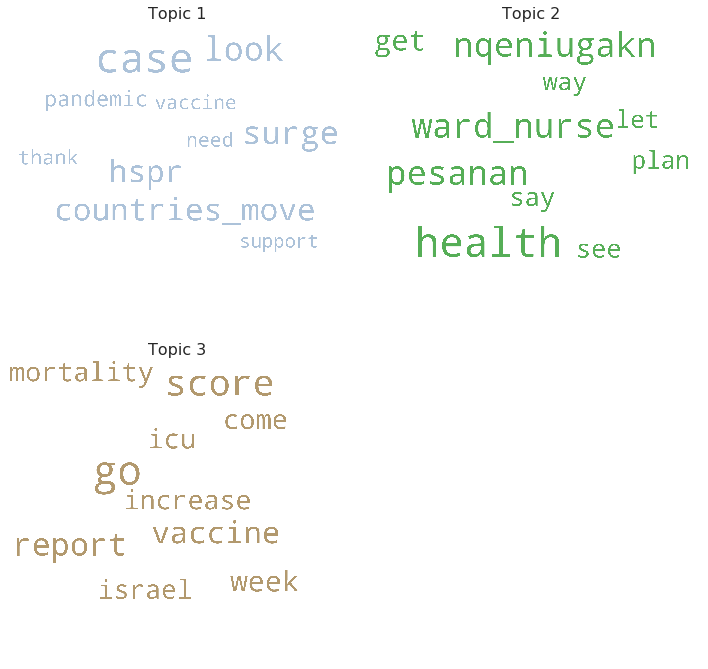

In [354]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS', fewer colors: 'mcolors.TABLEAU_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
      plt.gca().axis('off')
    except:
      continue


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Topic Keywords Counts
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the tweets is also interesting to see.

We will plot the word counts and the weights of each keyword in the same chart.

Look for words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important.

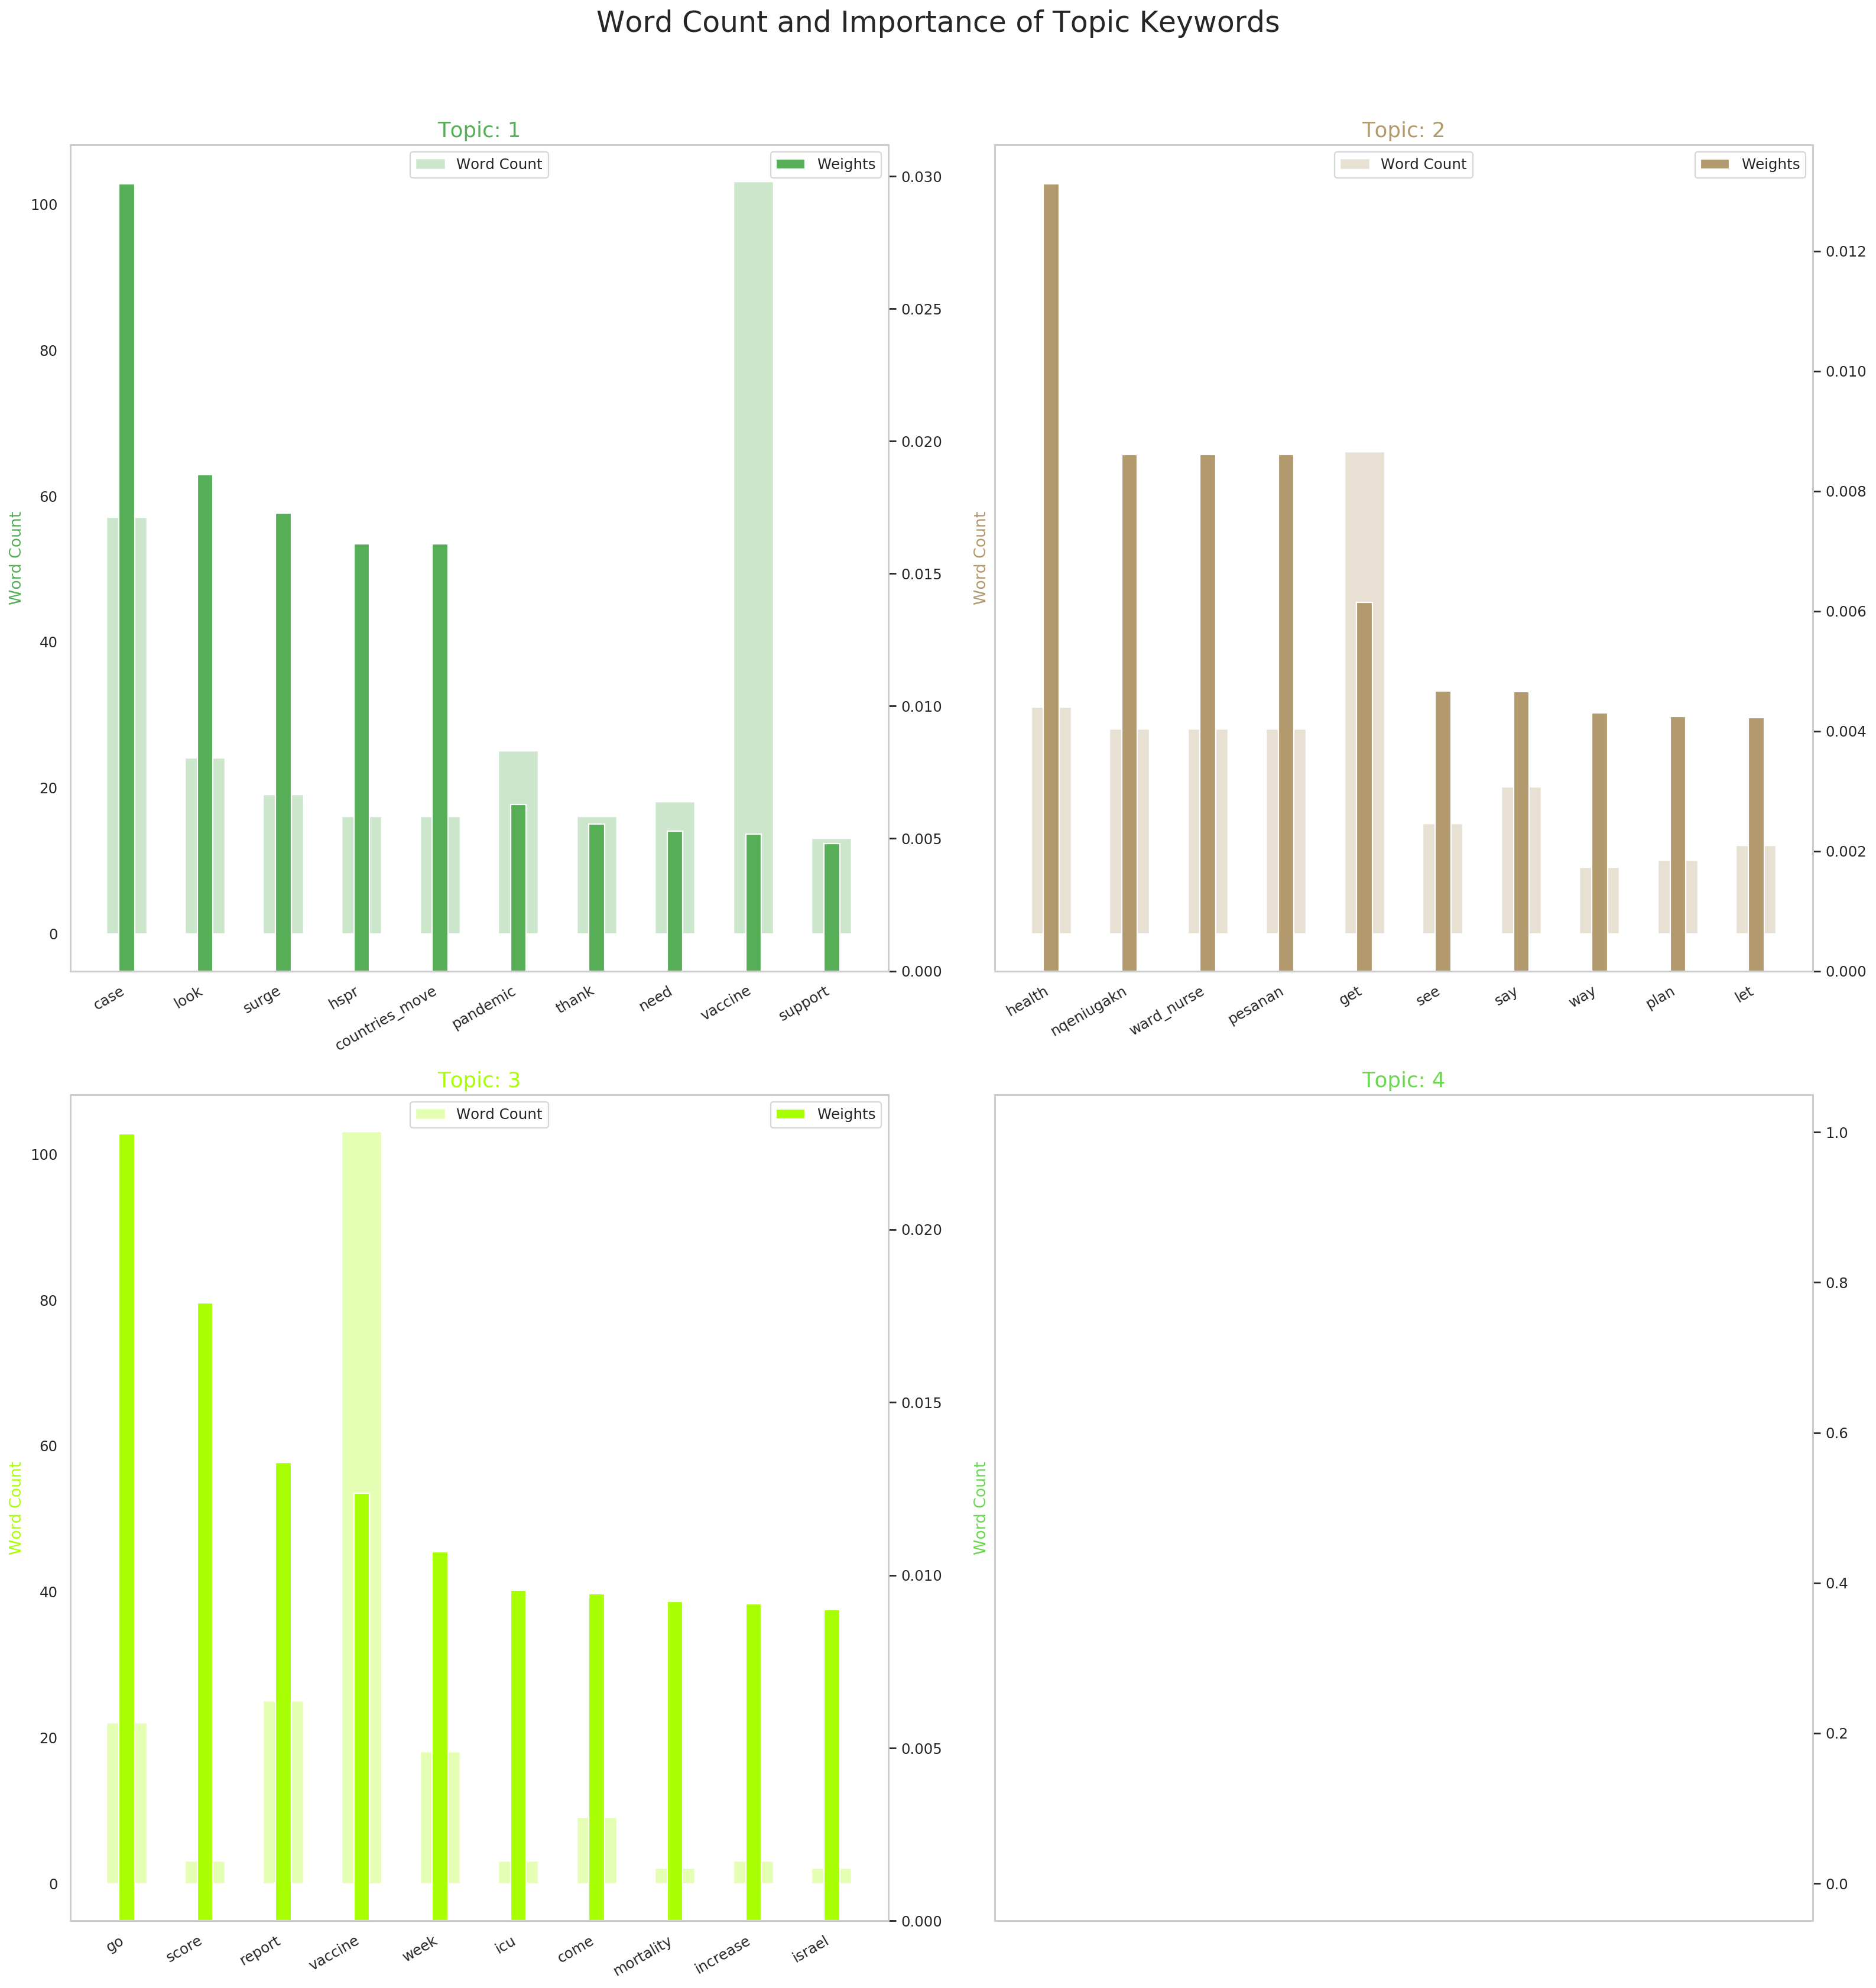

In [355]:
# Bar chart of word counts for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i + 1, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i+1])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
    try:
      ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
    except:
      pass

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored 
Each word in a tweet is representative of one of the 4 topics. You can color each word in a given tweet by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the tweet.

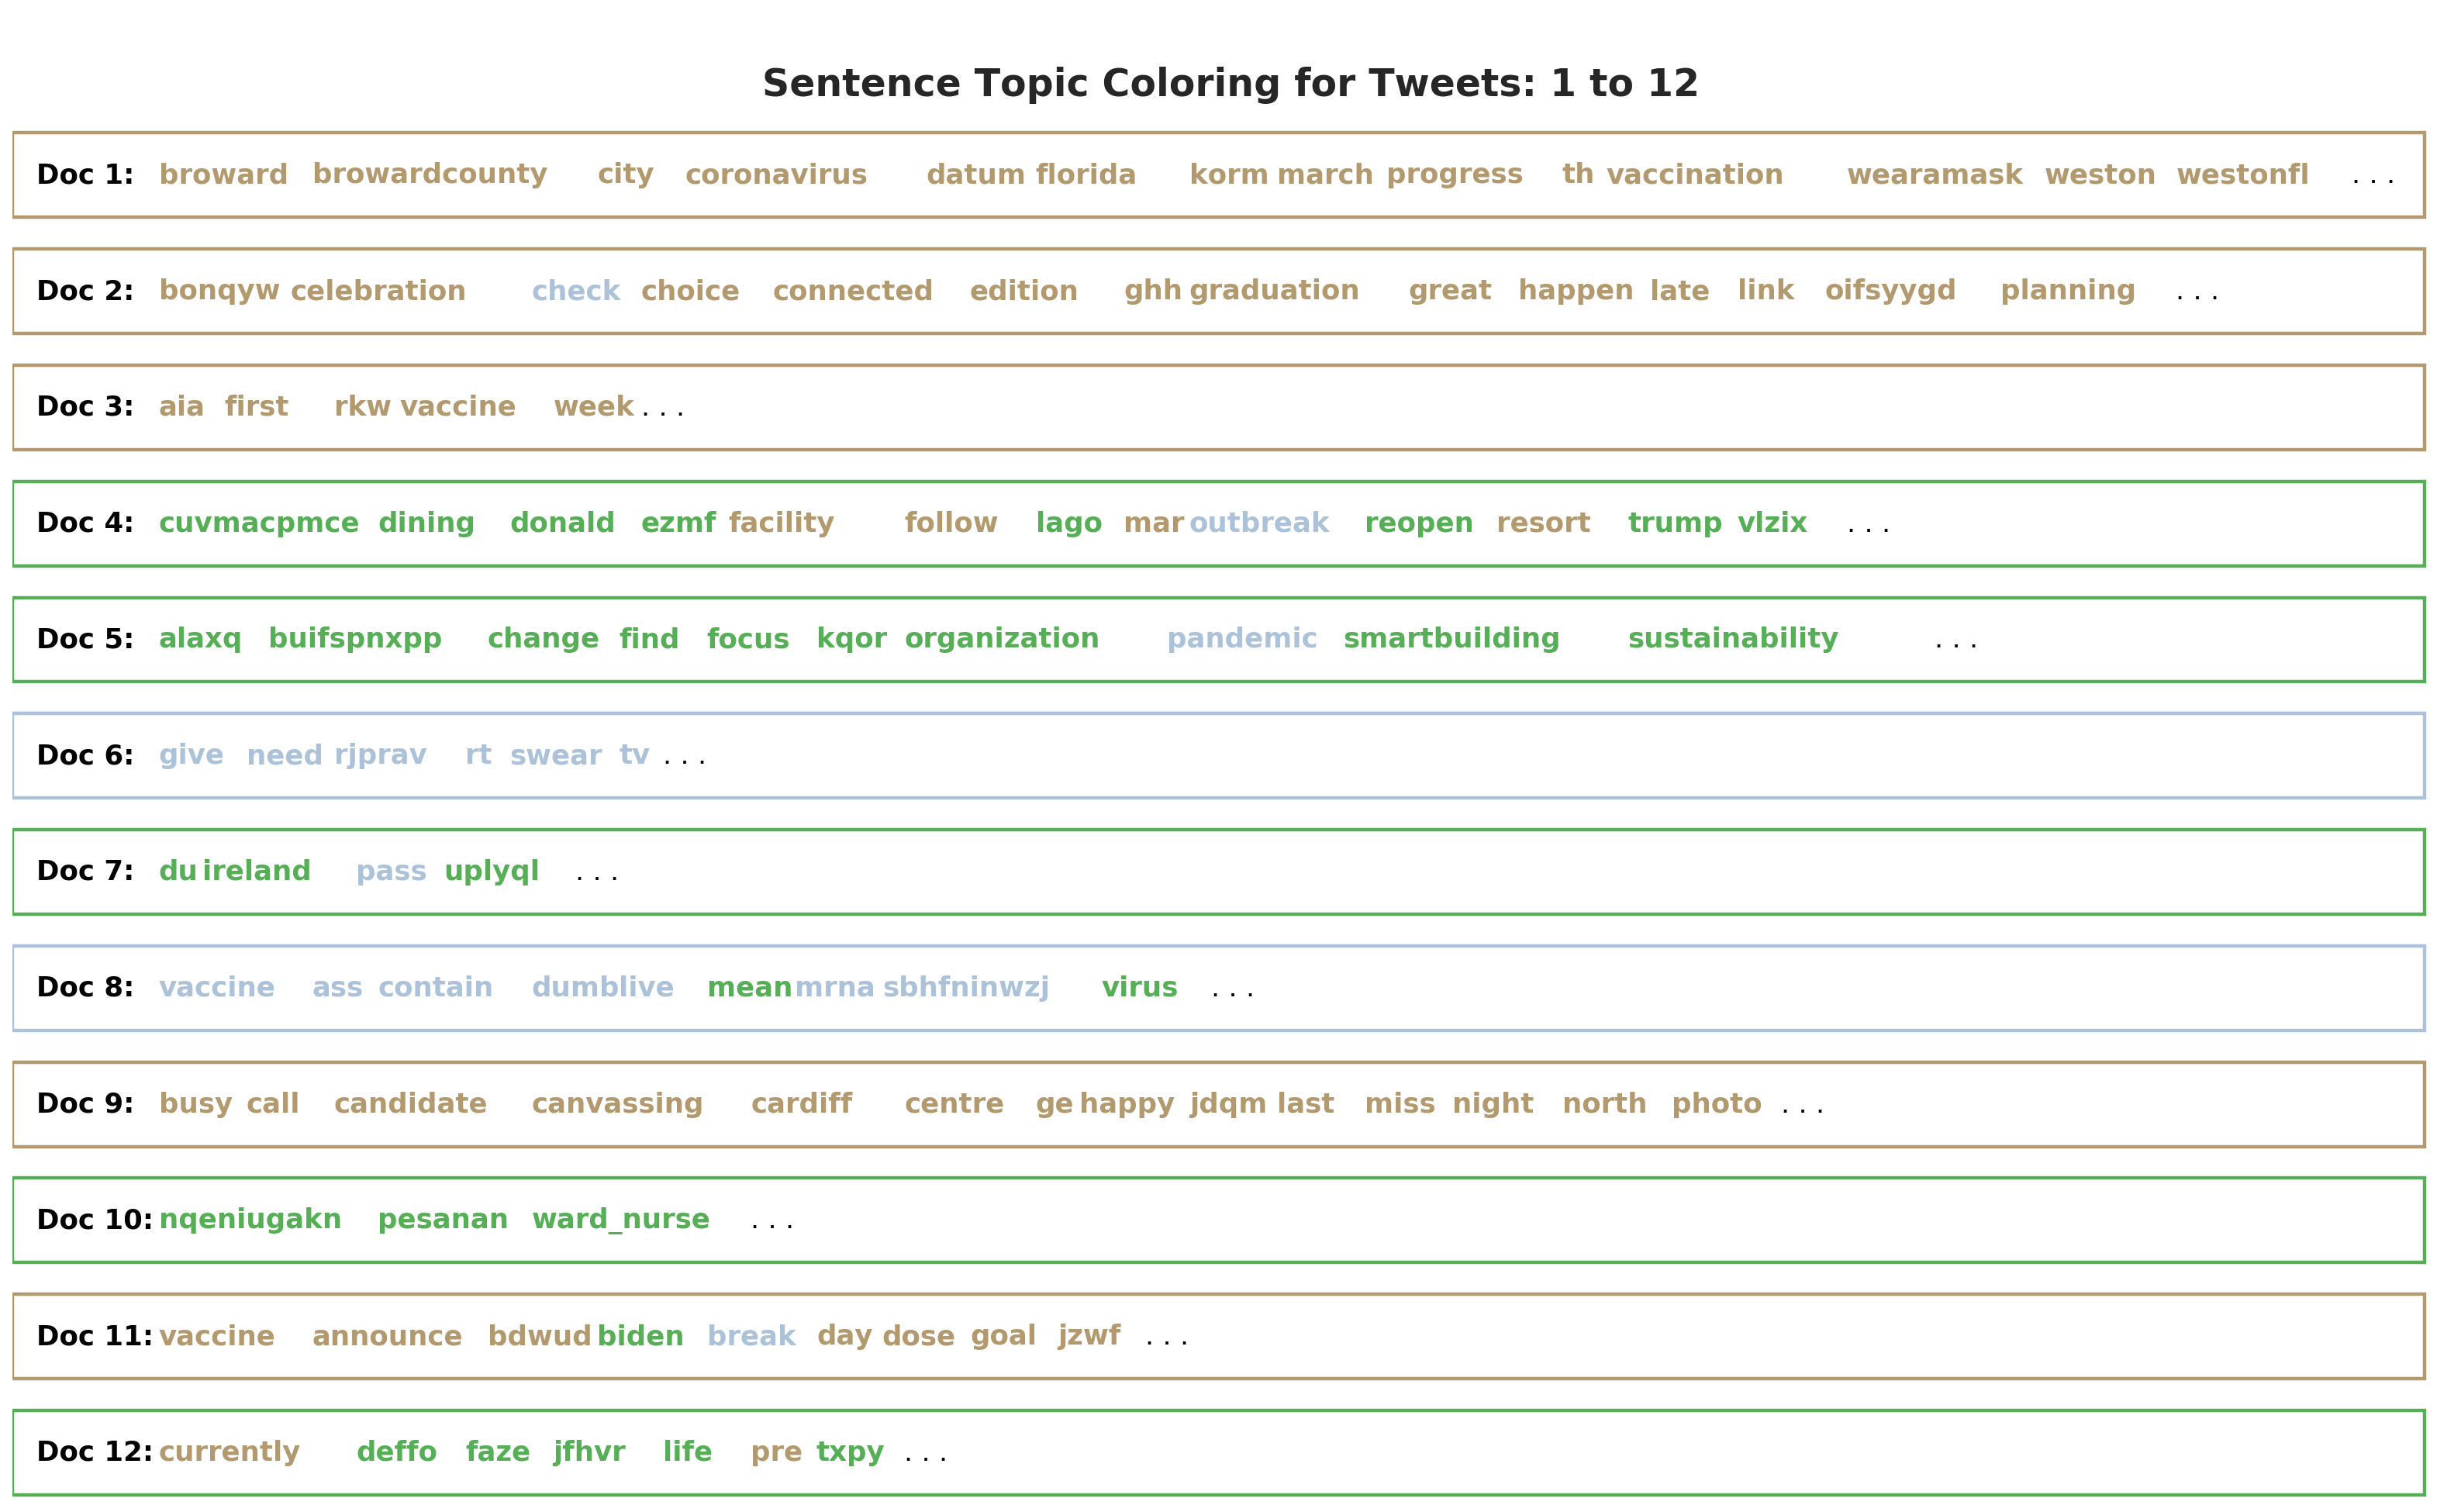

In [356]:
# Sentence Coloring of N Tweets
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.XKCD_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Tweets: ' + str(start + 1) + ' to ' + str(end-1), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

### Most Common Topics
What are the most discussed topics in the tweets? We can compute the total number of tweets attributed to each topic

In [357]:
# Generate a list of the most dominant topics and then the three top keywords in each of those topics
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

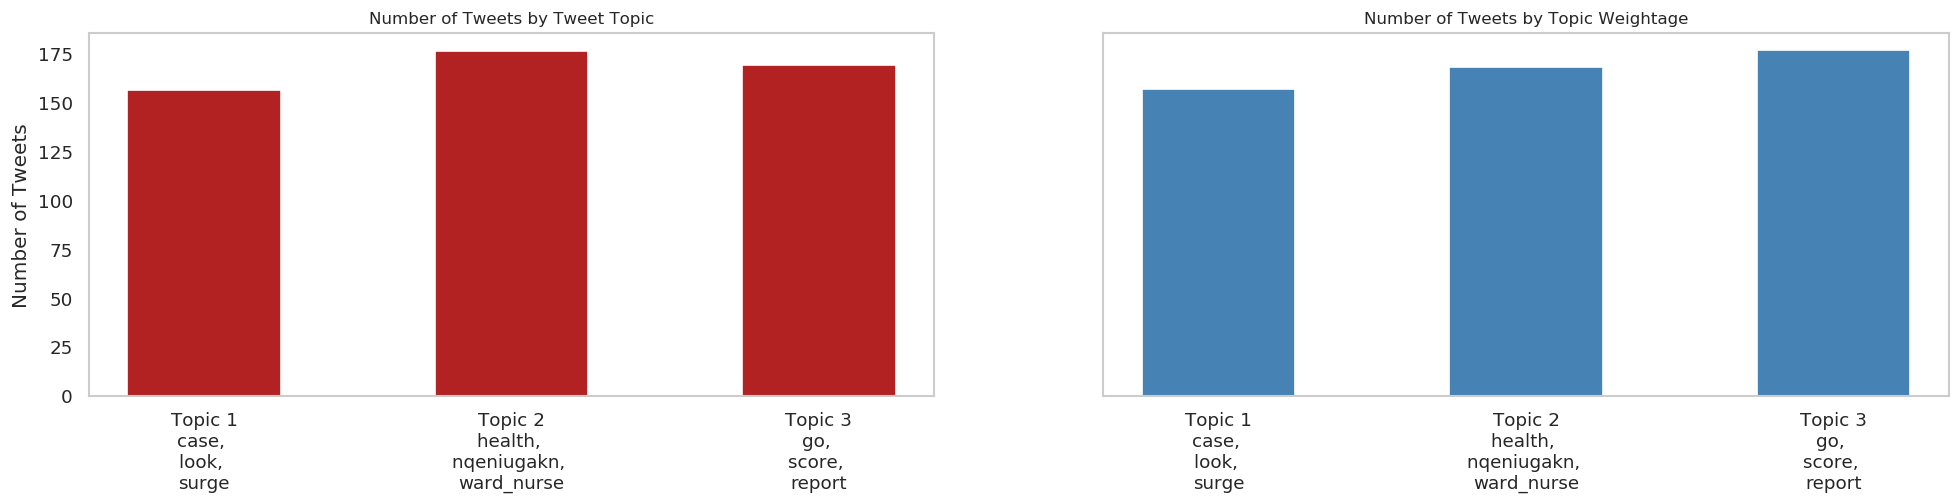

In [358]:
# Two Plots:
#    Num tweets per topic by assigning the document to the topic that has the most weight in that document.
#    Num tweets per topic by summing up the actual weight contribution of each topic to respective documents.

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Tweet Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Tweets by Tweet Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Tweets')
# ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Tweets by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart
Compute the total number of tweets attributed to each topic.

In [359]:
# Get topic weights and dominant topics
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 502 samples in 0.000s...
[t-SNE] Computed neighbors for 502 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 502 / 502
[t-SNE] Mean sigma: 0.001655
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.721558
[t-SNE] KL divergence after 900 iterations: 0.204877


Loading BokehJS ...

### pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model.

In [360]:
# For some reason, pyLDAVis doesn't seem to work in this AWS kernel. It appears there is a conflict between some of the conda libraries.
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
# viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# viz

## Dataset with LDA Topic Scores

In [361]:
import pandas as pd
df = pd.read_csv('twitter_with_LDA.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.head()

(502, 23)


,id,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,...,text,Weekday,DayOfWeek,Hour,words,Dominant_topic,Dominant_score,topic_1,topic_2,topic_3
0,1375208912442454018,2021-03-25 22:12:09+00:00,0,0,0,0,18,37,5,961,...,City of Weston / Broward COVID-19 Data and Flo...,Thursday,3,22,"['city', 'weston', 'broward', 'datum', 'florid...",3,0.964394,0.017714,0.017892,0.964394
1,1375208907837206529,2021-03-25 22:12:08+00:00,0,0,0,0,5669,651,138,8140,...,Check out our latest edition of Great Happens ...,Thursday,3,22,"['check', 'late', 'edition', 'great', 'happen'...",3,0.901700,0.083018,0.015282,0.901700
2,1375208902921486340,2021-03-25 22:12:07+00:00,0,0,0,0,442,878,3,16456,...,First Covid 19 vaccine done! 3 weeks until the...,Thursday,3,22,"['first', 'vaccine', 'week', 'rkw', 'aia']",3,0.879799,0.059717,0.060484,0.879799
3,1375208892695646212,2021-03-25 22:12:04+00:00,0,0,0,0,3646,133,236,95352,...,Donald Trump's Mar-a-Lago resort to reopen din...,Thursday,3,22,"['donald', 'trump', 'mar', 'lago', 'resort', '...",2,0.449203,0.126199,0.449203,0.424597
4,1375208876748988421,2021-03-25 22:12:01+00:00,0,0,0,0,1578,1087,106,4695,...,How has the COVID-19 pandemic changed how orga...,Thursday,3,22,"['pandemic', 'change', 'organization', 'focus'...",2,0.820656,0.148070,0.820656,0.031274


# Image Processing

## Download the Images

First, we will download all of the images we want to process and store them in S3. Let's first define a method that allows us to download an image from a URL and save it locally. The second block of code simply iterates over our data set and passes the URL and filename to the download_image function.

In [362]:
def download_image(url, name):
  import requests
  file_type = url.split('.')[-1]
  img_data = requests.get(url).content
  try:
    with open(f'images/{name}.{file_type}', 'wb') as handler:
      handler.write(img_data)
  except:
    with open(f'images/{name}.{file_type}', 'wb') as handler:
      handler.write(img_data)

In [363]:
for i, row in enumerate(df.itertuples()):
  if not pd.isnull(row.url):
    download_image(row.url, row.id)
    print(i, row.url, row.id)

0 https://pbs.twimg.com/media/ExW5NuSVEAEkjjK.jpg 1375208912442454018
1 https://pbs.twimg.com/media/ExW5NtDXAA4TXyT.jpg 1375208907837206529
2 https://pbs.twimg.com/media/ExW5NVRXIAc_n4k.jpg 1375208902921486340
3 https://pbs.twimg.com/media/ExW5MptVcAQLTrn.jpg 1375208892695646212
4 https://pbs.twimg.com/media/ExW5L4fXAAUvWas.jpg 1375208876748988421
5 https://pbs.twimg.com/media/ExVhA0JXEAM3whw.jpg 1375208866003181570
6 https://pbs.twimg.com/media/ExW5JbCXAAICOHG.jpg 1375208835758096384
7 https://pbs.twimg.com/media/ExW5IeLXIAYS36-.jpg 1375208821321252868
8 https://pbs.twimg.com/media/ExW5H3wXMAMR1Hu.jpg 1375208810499952643
9 https://pbs.twimg.com/media/ExTbVL_VgAEjzuz.jpg 1375208806209097728
10 https://pbs.twimg.com/media/ExV4ya1WUAEMQKq.jpg 1375208804976103425
11 https://pbs.twimg.com/media/Eq-TqITXYAADxgF.jpg 1375208800521715712
12 https://pbs.twimg.com/media/ExVllI-UUAEPPSZ.jpg 1375208799254896646
13 https://pbs.twimg.com/media/ExW5F1-WEAA-VyG.jpg 1375208776538677253
14 https://pbs.t

## Save them to S3 Bucket
Now that we have all of the files stored locally, we need to upload them to an S3 bucket.

In [379]:
import glob
import boto3
import os
import pandas as pd

bucket = "tmeservy-mldata"    # replace this with your bucket name
prefix = "photos/twitter" # replace this with the path to your images

In [380]:
#upload the files to the S3 bucket
images = glob.glob("images/*.jpg")
for filename in images:
  boto3.Session().resource('s3').Bucket(bucket).upload_file(filename,f'{prefix}/{os.path.basename(filename)}')

## Use AWS Rekognition to Scrape Entities

In [381]:
import pandas as pd
df = pd.read_csv('twitter_with_LDA.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)
df.head()

(502, 23)


,id,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,...,text,Weekday,DayOfWeek,Hour,words,Dominant_topic,Dominant_score,topic_1,topic_2,topic_3
0,1375208912442454018,2021-03-25 22:12:09+00:00,0,0,0,0,18,37,5,961,...,City of Weston / Broward COVID-19 Data and Flo...,Thursday,3,22,"['city', 'weston', 'broward', 'datum', 'florid...",3,0.964394,0.017714,0.017892,0.964394
1,1375208907837206529,2021-03-25 22:12:08+00:00,0,0,0,0,5669,651,138,8140,...,Check out our latest edition of Great Happens ...,Thursday,3,22,"['check', 'late', 'edition', 'great', 'happen'...",3,0.901700,0.083018,0.015282,0.901700
2,1375208902921486340,2021-03-25 22:12:07+00:00,0,0,0,0,442,878,3,16456,...,First Covid 19 vaccine done! 3 weeks until the...,Thursday,3,22,"['first', 'vaccine', 'week', 'rkw', 'aia']",3,0.879799,0.059717,0.060484,0.879799
3,1375208892695646212,2021-03-25 22:12:04+00:00,0,0,0,0,3646,133,236,95352,...,Donald Trump's Mar-a-Lago resort to reopen din...,Thursday,3,22,"['donald', 'trump', 'mar', 'lago', 'resort', '...",2,0.449203,0.126199,0.449203,0.424597
4,1375208876748988421,2021-03-25 22:12:01+00:00,0,0,0,0,1578,1087,106,4695,...,How has the COVID-19 pandemic changed how orga...,Thursday,3,22,"['pandemic', 'change', 'organization', 'focus'...",2,0.820656,0.148070,0.820656,0.031274


Initially, you may want to limit the number of rows that you are processing until you get your code working just right. You can use the following code to do so.

In [382]:
#limit number of rows for testing-if you don't want to process everything
#df=df.head(40)
#df.dtypes

In [383]:
#get the rekognition client
client = boto3.client('rekognition')

In [384]:
#get the s3 client
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)
#files = my_bucket.objects.filter(Prefix=prefix)

In previous classes when we processed images with Rekognition we retrieved a list of all files in S3 and then passed each file from the list to Rekognition. Here, instead, we will iterate over our dataframe and construct the name of the file we want it to process from the TweetID.

In [385]:
dfFaces = pd.DataFrame([])
i=0

for row in df.itertuples():
    file = f"{row.id}"
    extension = f"{row.url.split('.')[-1]}"
    print(f"Processing TweetID - {file}.{extension}")    
    if not pd.isnull(file):
        #print(i, row[1], file, f"{prefix}/{row[1]}.{file.split('.')[-1]}")
    
    
        if extension == 'jpg':
            # call rekognition for this next file
            response = client.detect_faces(
                Image={
                    'S3Object': {
                        'Bucket': bucket,
                        'Name': f"{prefix}/{file}.{extension}"
                    }
                },
                Attributes=[
                    'ALL',
                ]
            )

            # now add all of the facial features for every person found in the photo
            for fd in response["FaceDetails"]:    
                i=i+1
                dfFaces.loc[i,'TweetID'] = file
                dfFaces.loc[i,'PersonID'] = i
                dfFaces.loc[i,'AgeRange-Low'] = fd["AgeRange"]["Low"]
                dfFaces.loc[i,'AgeRange-High'] = fd["AgeRange"]["High"]
                dfFaces.loc[i,'Smile'] = fd["Smile"]["Value"]
                dfFaces.loc[i,'Gender'] = fd["Gender"]["Value"]
                dfFaces.loc[i,'Emotion'] = fd["Emotions"][0]["Type"] #get dominant emotion
                dfFaces.loc[i,'Emotion-Confidence'] = fd["Emotions"][0]["Confidence"] #get dominant emotion



Processing TweetID - 1375208912442454018.jpg
Processing TweetID - 1375208907837206529.jpg
Processing TweetID - 1375208902921486340.jpg
Processing TweetID - 1375208892695646212.jpg
Processing TweetID - 1375208876748988421.jpg
Processing TweetID - 1375208866003181570.jpg
Processing TweetID - 1375208835758096384.jpg
Processing TweetID - 1375208821321252868.jpg
Processing TweetID - 1375208810499952643.jpg
Processing TweetID - 1375208806209097728.jpg
Processing TweetID - 1375208804976103425.jpg
Processing TweetID - 1375208800521715712.jpg
Processing TweetID - 1375208799254896646.jpg
Processing TweetID - 1375208776538677253.jpg
Processing TweetID - 1375208757601390593.jpg
Processing TweetID - 1375208725359816704.jpg
Processing TweetID - 1375208719609397252.jpg
Processing TweetID - 1375208693684310018.jpg
Processing TweetID - 1375208681218977797.jpg
Processing TweetID - 1375208670443630597.jpg
Processing TweetID - 1375208665888743429.jpg
Processing TweetID - 1375208663539974144.jpg
Processing

In [386]:
dfFaces.describe

<bound method NDFrame.describe of                  TweetID  PersonID  AgeRange-Low  AgeRange-High  Smile  \
1    1375208907837206529       1.0          15.0           27.0  False   
2    1375208907837206529       2.0          17.0           29.0  False   
3    1375208876748988421       3.0          18.0           30.0   True   
4    1375208810499952643       4.0          23.0           35.0   True   
5    1375208810499952643       5.0          15.0           27.0   True   
..                   ...       ...           ...            ...    ...   
746  1375205027384463362     746.0          38.0           56.0  False   
747  1375204977040183296     747.0          19.0           31.0  False   
748  1375204975949844484     748.0          10.0           20.0  False   
749  1375204940642148366     749.0          22.0           34.0  False   
750  1375204899881897985     750.0          23.0           35.0  False   

     Gender Emotion  Emotion-Confidence  
1    Female    CALM           81.57

In this example we extracted information from people that were detected in the image. Of course, we could have used other Rekgonition methods to extract text or identify different types of objects that were identified. We now need to summarize this data into a single row for each tweet.

In [387]:
dfFaceSummary = pd.DataFrame([])

#summarize stats per file
#aggregate functions include min, max, mean, count, and more.
dfFaceSummary['Count-People'] = dfFaces.groupby('TweetID')['PersonID'].count()
dfFaceSummary['Avg-AgeRange-Low'] = dfFaces.groupby('TweetID')['AgeRange-Low'].min()
dfFaceSummary['Avg-AgeRange-High'] = dfFaces.groupby('TweetID')['AgeRange-High'].max()
dfFaceSummary['Count-Smile'] = dfFaces[dfFaces['Smile']==True].groupby('TweetID')['Smile'].count()
dfFaceSummary['Count-Smile'] = dfFaceSummary['Count-Smile'].fillna(0)
dfFaceSummary['Percent-Smile'] = dfFaceSummary['Count-Smile']/df2['Count-People']
dfFaceSummary['Percent-Smile'] = dfFaceSummary['Percent-Smile'].fillna(0)

dfFaceSummary = dfFaceSummary.merge(dfFaces.groupby('TweetID')['Emotion'].value_counts().unstack().fillna(0), on='TweetID')
dfFaceSummary = dfFaceSummary.merge(dfFaces.groupby('TweetID')['Gender'].value_counts().unstack().fillna(0), on='TweetID')

#print out 
dfFaceSummary


,Count-People,Avg-AgeRange-Low,Avg-AgeRange-High,Count-Smile,Percent-Smile,ANGRY,CALM,CONFUSED,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
TweetID,,,,,,,,,,,,,,,
1375204899881897985,1,23.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1375204940642148366,1,22.0,34.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1375204975949844484,1,10.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1375204977040183296,1,19.0,31.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1375205027384463362,1,38.0,56.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375208719609397252,2,21.0,47.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1375208804976103425,1,62.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1375208810499952643,4,15.0,45.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0


Now that we have summary information, we need to merge it back to our data frame and save it to a CSV file so that we can use it during modeling.

In [388]:
#the tweet id is an object, so we need to convert it to the same data type as our id
dfFaceSummary.index = dfFaceSummary.index.astype(int)

#Now merge the frames together
df = df.merge(dfFaceSummary, left_on='id', right_on='TweetID')
df


,id,created_at,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,...,ANGRY,CALM,CONFUSED,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
0,1375208907837206529,2021-03-25 22:12:08+00:00,0,0,0,0,5669,651,138,8140,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,1375208876748988421,2021-03-25 22:12:01+00:00,0,0,0,0,1578,1087,106,4695,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1375208810499952643,2021-03-25 22:11:45+00:00,0,0,0,0,6692,7364,108,62671,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0
3,1375208804976103425,2021-03-25 22:11:43+00:00,47,0,0,0,179,722,0,20101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1375208719609397252,2021-03-25 22:11:23+00:00,0,1,0,0,306,2109,6,11324,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1375205027384463362,2021-03-25 21:56:43+00:00,0,0,0,0,246,249,15,12543,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
196,1375204977040183296,2021-03-25 21:56:31+00:00,142,0,0,0,28,125,0,1027,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
197,1375204975949844484,2021-03-25 21:56:30+00:00,0,0,0,0,37,236,0,52897,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
198,1375204940642148366,2021-03-25 21:56:22+00:00,0,0,0,0,2529,2201,2,3524,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [389]:
#now save this out to a new csv
df.to_csv('twitter_with_LDA_and_image_data.csv', index=False)

# Modeling

In [390]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regression algorithm
from sklearn.ensemble import GradientBoostingRegressor # Import XGBoost algorithm 
from sklearn.model_selection import train_test_split # Import train_test_split function
# for a completelist of available algorithms: https://scikit-learn.org/stable/supervised_learning.html
# Which one should I use?: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

df = pd.read_csv('twitter_with_LDA_and_image_data.csv')
# Convert these numbers to categories
df['id'] = df['id'].astype('object')
print(df.shape)

# Determine what you want to predict:
label = 'retweets'

(200, 38)


In [391]:
# Print out the columns so that we can identify which ones we want to drop (e.g. unique identifiers, original text before processing, image file names, dates)
for col in df.columns:
  print(f'\'{col}\', ', end="")

drop_list = ['id', 'created_at', 'url', 'text', 'words', 'File', 'PersonID', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9']

'id', 'created_at', 'retweets', 'likes', 'replies', 'quotes', 'user_followers', 'user_following', 'user_listed', 'user_tweets', 'has_media', 'url', 'lang', 'text', 'Weekday', 'DayOfWeek', 'Hour', 'words', 'Dominant_topic', 'Dominant_score', 'topic_1', 'topic_2', 'topic_3', 'Count-People', 'Avg-AgeRange-Low', 'Avg-AgeRange-High', 'Count-Smile', 'Percent-Smile', 'ANGRY', 'CALM', 'CONFUSED', 'DISGUSTED', 'FEAR', 'HAPPY', 'SAD', 'SURPRISED', 'Female', 'Male', 

In [392]:
# Eliminate anything remaining in the drop list without throwing an error in case we removed it earlier
for col in df.columns:
  if col in drop_list:
    try:
      df.drop(columns=[col], inplace=True)
    except:
      continue



In [393]:
df.head()
#df.dtypes

,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,has_media,lang,...,ANGRY,CALM,CONFUSED,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Female,Male
0,0,0,0,0,5669,651,138,8140,True,en,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0,0,0,0,1578,1087,106,4695,True,en,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0,0,0,0,6692,7364,108,62671,True,en,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,2.0
3,47,0,0,0,179,722,0,20101,True,en,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,1,0,0,306,2109,6,11324,True,en,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


In [394]:
df.dropna(inplace=True)       # Remove any rows with null values
print(f'Records: {len(df)}')  # Count and print the number of rows remaining



Records: 200


In [395]:
df['Dominant_topic'] = df['Dominant_topic'].astype('object') # Topics are categorical so this needs to be modified since it's a number



In [396]:
# Create dummy codes for all features and not the label
for col in df.columns:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col)
    



In [397]:
# Eliminate columns with only one unique value:
for col in df.columns:
  if (df[col].nunique() < 2):
    try:
      df.drop(columns=[col], inplace=True)
    except:
      continue

In [398]:
df

,retweets,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,Hour,Dominant_score,...,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Female,Male,Dominant_topic_1,Dominant_topic_2,Dominant_topic_3
0,0,0,0,0,5669,651,138,8140,22,0.901700,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,1
1,0,0,0,0,1578,1087,106,4695,22,0.820656,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0
2,0,0,0,0,6692,7364,108,62671,22,0.965820,...,0.0,0.0,3.0,0.0,0.0,2.0,2.0,0,0,1
3,47,0,0,0,179,722,0,20101,22,0.566098,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,1
4,0,1,0,0,306,2109,6,11324,22,0.808384,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0,0,0,246,249,15,12543,21,0.836076,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
196,142,0,0,0,28,125,0,1027,21,0.904601,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0
197,0,0,0,0,37,236,0,52897,21,0.789610,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0
198,0,0,0,0,2529,2201,2,3524,21,0.603998,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0


In [399]:
# Split dataset in features and target variable

y = df[label] # Label
X = df.drop(columns=[label]) # Features
X = X.select_dtypes(np.number)

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train.head()

,likes,replies,quotes,user_followers,user_following,user_listed,user_tweets,Hour,Dominant_score,Count-People,...,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Female,Male,Dominant_topic_1,Dominant_topic_2,Dominant_topic_3
116,0,0,0,787,688,22,2916,22,0.744328,2,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,1
67,0,0,0,310,411,0,17615,22,0.899722,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
78,0,0,0,8125,2621,236,15451,22,0.798538,2,...,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0,1,0
42,0,0,0,958,226,47,123649,22,0.971861,7,...,0.0,0.0,0.0,0.0,1.0,1.0,6.0,0,0,1
17,0,0,0,44,197,2,198,22,0.621835,3,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,0,0


In [401]:
# This Linear Regression is only for model interpretation purposes

import statsmodels.api as sm

# Run the multiple linear regression model
model = sm.OLS(y, X)
results = model.fit()

# View results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.7800
Date:                Fri, 26 Mar 2021   Prob (F-statistic):              0.753
Time:                        17:50:27   Log-Likelihood:                -1627.8
No. Observations:                 200   AIC:                             3304.
Df Residuals:                     176   BIC:                             3383.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
likes                -6.8218     47.67

In [ ]:
# Create Decision Tree regressor object
clf = DecisionTreeRegressor()

# Train Decision Tree regressor
clf = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clf.predict(X_test)

In [ ]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

In [ ]:
# Import scikit-learn metrics module. See complete list of Classification metrics here: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

In [ ]:
# Create XGBoost regressor object
clr = GradientBoostingRegressor()

# Train Decision Tree regression
clr = clf.fit(X_train,y_train)

# Predict the labels for test dataset
y_pred = clr.predict(X_test)

In [ ]:
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
output_df.head(10)

In [ ]:
from sklearn import metrics
    
print(f'R squared:\t{metrics.r2_score(y_test, y_pred)}')
print(f'MAE:\t\t{metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:\t\t{metrics.mean_squared_error(y_test, y_pred)**(1/2)}')

In [ ]:
import pickle

# Save the model with the highest fit metric
pickle.dump(clr, open('stored_model.sav', 'wb'))  # OPTION 1: pickle

In [ ]:
# ...some time later

import pickle
import numpy as np

# OPTION 1: Using pickle
# load the model from 'stored_model.sav'
loaded_model = pickle.load(open('stored_model.sav', 'rb'))

# for a single prediction, enter a row of data and reshape into numpy array
case = X_test.iloc[0]
print(f'Single prediction:\t{loaded_model.predict(np.array(case).reshape(1, -1))[0]}\n\n{case}\n')

# for a batch prediction, enter a Pandas DataFrame or a Numpy array of arrays
predictions = loaded_model.predict(X_test) 
batch_results = pd.DataFrame({'Actual':y_test, 'Predicted':predictions, 'Diff':(predictions - y_test)})
print(f'MAE:\t{batch_results.Diff.abs().mean()}\n')
batch_results.head(5)